In [11]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

##choose one
bert_pretrained='bert-base-uncased'
#bert_pretrained='bert-base-multilingual-cased' too large

#datasource='http://www.statmt.org/wmt10/training-giga-fren.tar'

#inspiration for this code
#https://www.kaggle.com/code/adewoleakorede/english-french-translator/notebook
#https://www.kaggle.com/code/harishreddy18/english-to-french-translation/notebook
#https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation
#https://blog.aiensured.com/untitled-7/
#https://medium.com/@sachinsoni600517/masked-multi-head-attention-in-transformer-f3e096d56961
#for further comparison https://huggingface.co/docs/transformers/tasks/translation
##--->see https://arxiv.org/pdf/1907.12461


def load_data(file,lmax=None):
    ''' 
    Files to read are in GB, this is not readable on a jupyter notebook
    Files are read from line 0 to line lmax
    '''

    if lmax==None:
        lmax=100

    Sentences=[]
    i=0
    f=open(file,encoding='utf-8')
    while i <lmax:
        line=f.readline()
        line=line.strip('\n')
        sentences=line.split(' | ')
        Sentences.append(sentences)
        i=i+1
    f.close()

    mylist=sum(Sentences,[]) # flattening, transform a list of list into a simplelist

    return mylist


example_file='translation_examples.csv'
if os.path.exists(example_file)==0:
    fr_file = 'Data/giga-fren.release2.fixed.fr'
    en_file = 'Data/giga-fren.release2.fixed.en'

    fr_text = load_data(fr_file,lmax=50)
    en_text = load_data(en_file,lmax=50)

    df_fr=pd.DataFrame(data=fr_text)
    df_en=pd.DataFrame(data=en_text)

    Df=pd.concat([df_fr.T,df_en.T]).T
    Df.columns=['fr','en']
    print(Df.head())
    Df.to_csv(example_file ,encoding='utf-8')

else:
    Df=pd.read_csv(example_file, encoding='utf-8')
    fr_text=Df['fr'].to_list()
    en_text=Df['en'].to_list()
    print(fr_text[0:5])
    print(en_text[0:5])



X_train, X_test, y_train, y_test = train_test_split(fr_text, en_text, test_size=0.2, random_state=42)

['Il a transformé notre vie', 'Il a transformé la société', 'Son fonctionnement', 'La technologie, moteur du changement Accueil', 'Concepts']
['Changing Lives', 'Changing Society', 'How It Works', 'Technology Drives Change Home', 'Concepts']


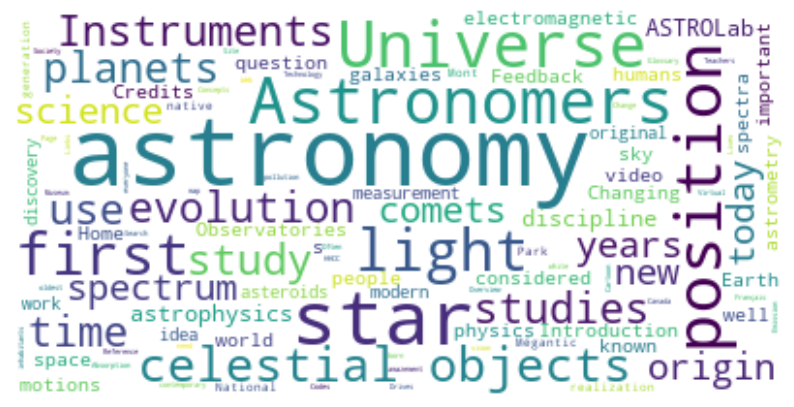

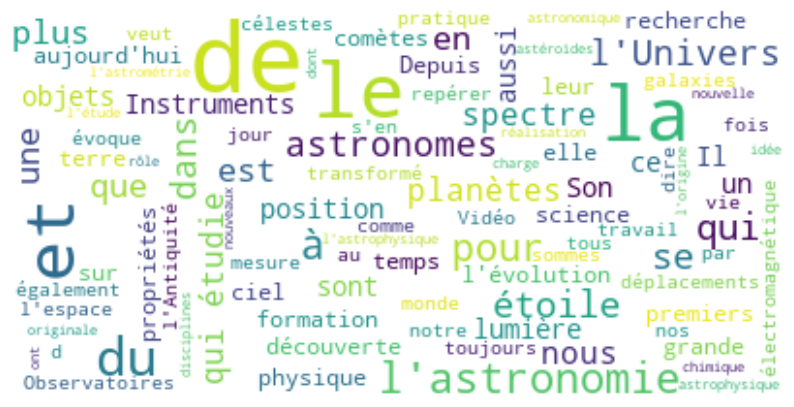

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# generate wordcloud for english text
wordcloud = WordCloud(max_words=100, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate( ' '.join(en_text) )

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

wordcloud = WordCloud(max_words=100, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate( ' '.join(fr_text) )

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()


In [13]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(bert_pretrained)

#note : maybe use Bert from tensorflow API?;more option https://www.tensorflow.org/text/api_docs/python/text/BertTokenizer
# or usi keras API? from tensorflow.keras.preprocessing.text import Tokenizer
# note sure 

def tokenize_(Batchoftext):
    ''' 
    transform a batch of sentences into token with id and attention mask with help of Bert pretrainmodel
    Bert pretrained model 
    Some text are too long... i think this will cause error, see later
    '''
    # see https://medium.com/axinc-ai/how-tokenizer-parameters-impact-transformers-behavior-8be8030637c6
    Tok = tokenizer(Batchoftext,
                    max_length=512,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'# pytorch tensor
                    
    )

    return Tok#Tok['input_ids'], Tok['attention_mask']


train_input_ids=tokenize_(X_train)['input_ids']
val_input_ids=tokenize_(X_test)['input_ids']
train_labels_ids=tokenize_(y_train)['input_ids']
val_labels_ids=tokenize_(y_test)['input_ids']

train_attention_masks = tokenize_(X_train)['attention_mask']
val_attention_masks = tokenize_(X_test)['attention_mask']


In [14]:
#example 
print(tokenizer('I am going to school'))
print('\n')

#see padding effect when decoding ; [PAD] fill the text to batchoftext max length 
print(X_test[1])
print (tokenizer.decode(val_labels_ids[1],skip_special_tokens=True))
#val_labels[1]

{'input_ids': [101, 1045, 2572, 2183, 2000, 2082, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


Enseignants
teachers


In [15]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4


train_dataset = TensorDataset(train_input_ids,#type(torch.int64)
                              train_attention_masks,
                              train_labels_ids
                              )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)# shuffle=True? not sur if shuffle will be the same in the two loaded


val_dataset = TensorDataset(val_input_ids,#.type(torch.int64),
                            val_attention_masks, 
                            val_labels_ids
                            )
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)#shuffle=True?





In [16]:
#BERT to BERT

#from transformers import BertConfig, BertForMaskedLM , get_linear_schedule_with_warmup
from transformers import BertGenerationEncoder, BertGenerationDecoder, EncoderDecoderModel
import torch.nn as nn
#from sklearn.utils.class_weight import compute_class_weight
import torch


#max_seq_length = 512  # Max token limit for BERT
#config = BertConfig.from_pretrained(bert_pretrained, num_labels=max_seq_length)
#model = BertForMaskedLM.from_pretrained(bert_pretrained, config=config)
encoder = BertGenerationEncoder.from_pretrained(bert_pretrained,
                                                bos_token_id=101,
                                                eos_token_id=102)

decoder=BertGenerationDecoder.from_pretrained(bert_pretrained,
                                                add_cross_attention=True,
                                                is_decoder=True,
                                                bos_token_id=101,
                                                eos_token_id=102)

# I think best would be to combine any bidirectional text encoder (e.g. BERT) with a autoregressive text decoder (e.g. GPT2).
# but I want bert2bert for now


model=EncoderDecoderModel(  encoder=encoder, 
                            decoder=decoder) 



## sharing weight reduce memory needs by half https://huggingface.co/blog/warm-starting-encoder-decoder
#model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-cased", "bert-base-cased", tie_encoder_decoder=True)

#adding some config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id


#model

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.
You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.
Some weights of BertGenerationDecoder were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossatte

In [17]:
### a quick test before Fine tuning
import numpy as np
import tensorflow as tf
z=train_dataset[0]
sent_id,att_mask,val_id=z

label=train_labels_ids[0]


out=model.forward(  input_ids=sent_id.unsqueeze(0),
                    attention_mask=att_mask.unsqueeze(0),
                    labels=val_id.unsqueeze(0),output_attentions=True ) 

print(out.loss)
print(out.logits)

txt = 'une phrase a traduire'
inputs = tokenizer(txt, return_tensors="pt").to(device)['input_ids']
trad="A sentence to translate"
valu = tokenizer(trad, return_tensors="pt").to(device)['input_ids']
out=model(input_ids=inputs,labels=valu)

zz=tf.math.argmax(out.logits.detach().numpy(),axis=-1)
#print(zz)
print(txt)
print(tokenizer.decode(zz[0]))




c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:557: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)


tensor(10.4774, grad_fn=<NllLossBackward0>)
tensor([[[-0.2389, -0.1756, -0.1798,  ..., -0.4846,  0.4260, -0.0500],
         [-0.2232, -0.1633, -0.1649,  ..., -0.4675,  0.4545, -0.0627],
         [ 0.2925,  0.2401,  0.3184,  ...,  0.7137,  1.1161, -0.6866],
         ...,
         [-0.0872, -0.0460, -0.0329,  ...,  0.9961,  1.1908, -0.6385],
         [-0.2103, -0.1659, -0.1382,  ...,  0.9078,  1.0935, -0.6596],
         [-0.0562, -0.0107, -0.0056,  ...,  0.9587,  1.2274, -0.5422]]],
       grad_fn=<ViewBackward0>)
une phrase a traduire
homo homoocene queardo [CLS]


c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [18]:
# import evaluate
# metric = evaluate.load("sacrebleu")
# metric.compute(predictions='Some sentence', references=trad)

In [21]:
from torch.optim import AdamW
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=len(train_dataloader)/4,
                                            num_training_steps=6*len(train_dataloader)
                                            )
# define the loss function
cross_entropy  = nn.NLLLoss() #Negative log likelihood loss ; good for classification
#cross_entropy= torch.nn.CrossEntropyLoss() # Loss function


#weights = weights.to(device)
def train_model():
    ''' 
    BERT model - train the model
    '''
    model.train()

    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        #batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(input_ids=sent_id,
                      attention_maks=mask,#attention mask is important because of  padding
                      #decoder_input_ids=labels,
                      labels=labels
                      )
        
        # log_preds = F.log_softmax(preds.logits, dim=-1)
        # loss = cross_entropy(log_preds.view(-1, tokenizer.vocab_size), 
        #                     labels.view(-1).long()#add .long() is using torch.nn.CrossEntropyLoss or use.type(torch.LongTensor)
        #                     )
        loss=preds.loss
        loss.backward()
        total_loss = total_loss + loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_dataloader)

    return avg_loss


def evaluate_model():
    ''' 
    BERT model - evaluate the model
    '''
    model.eval()
    total_loss=0

    for step, batch in enumerate(val_dataloader):

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad(): # do NOT compute gradient; gradient is computed in training only

            # get model predictions for the current batch
            preds = model(  input_ids=sent_id,
                            attention_maks=mask,#attention mask is important because of  padding
                            #decoder_input_ids=labels,
                            labels=labels
                            )
            
            # log_preds = F.log_softmax(preds.logits, dim=-1)
            
            # loss = cross_entropy(log_preds.view(-1, tokenizer.vocab_size), 
            #                     labels.view(-1).long()#add .long() is using torch.nn.CrossEntropyLoss or use.type(torch.LongTensor)
            #                     )

            loss=preds.loss
            total_loss = total_loss + loss.item()

    avg_loss = total_loss / len(train_dataloader)

    return avg_loss

In [22]:
### FINE TUNING

epochs=4

best_loss=1e6 #a really high value

for epoch in range(epochs):

    train_loss=train_model()
    valid_loss=evaluate_model()
    print(f'Epoch {epoch+1}/{epochs} - Training loss: {train_loss} - Validation loss: {valid_loss}')


    if valid_loss< best_loss:
        best_loss = valid_loss
        best_model = model

best_model=model


model_save_path = "bert_translation_model.pt"
torch.save(best_model, model_save_path)


Epoch 1/4 - Training loss: 7.762762387593587 - Validation loss: 1.9190922975540161
Epoch 2/4 - Training loss: 5.493989984194438 - Validation loss: 1.6530648469924927
Epoch 3/4 - Training loss: 4.799873352050781 - Validation loss: 1.4347212314605713
Epoch 4/4 - Training loss: 4.228225290775299 - Validation loss: 1.2787584066390991


In [23]:
model_save_path = "bert_translation_model.pt"
model=torch.load(model_save_path, weights_only=False)
model.eval()


EncoderDecoderModel(
  (encoder): BertGenerationEncoder(
    (embeddings): BertGenerationEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertGenerationLayer(
          (attention): BertGenerationAttention(
            (self): BertGenerationSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertGenerationSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [24]:
def generate_trad(model, sentence):
    ''' 
    generate a translation from french to english (for now) by using the EncoderDecoder model 
    '''
    inputs=tokenize_(sentence)

    predic=model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    #print(predic.view(-1))

    out=tokenizer.decode(predic.view(-1))#,skip_special_tokens=True)

    return out



sentence= X_test[1]
print(sentence)
generate_trad(model, sentence)


Enseignants


'[CLS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'